In [67]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle
#os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
#lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py') 
sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/moises/Downloads')) #Current directory

In [68]:
mode = lumapi.MODE(filename= 'MMI_2X8.lms')


In [69]:
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })


In [85]:
BdX_Span = 99e-6 # Body X Span
W = 18e-6 # Body y Span

InP = 2 
OutP = 8 
TLen = 5e-6 
TWidth = 1.42e-6
MeshEnable = 0
SetToTappers = 1

EME_MC = 20 # Number of EME Mesh Cells (Y and Z)
SideCells = 15 # Number of Cells on Input/Output groups

In [86]:
mode.switchtolayout()
mode.selectall()
mode.delete()


RectInsert(BdX_Span/2,BdX_Span, 0,  W, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mode)
mode.set("name","MMI")

mode.addobject("linear_taper")
mode.set({"first axis":"z", "rotation 1":180,
"angle_side":90,
"x":-TLen/2, "z":0, "len":TLen,
"thickness":0.22e-6,
"width_l":TWidth,
"width_r": 0.45e-6,  
"name":"Input Taper "})
mode.set("y",W/6)

mode.addobject("linear_taper")
mode.set({"first axis":"z", "rotation 1":180,
"angle_side":90,
"x":-TLen/2, "z":0, "len":TLen,
"thickness":0.22e-6,
"width_l":TWidth,
"width_r": 0.45e-6,   
"name":"Input Taper "})
mode.set("y",-W/6)


##input retangulos
RectInsert(-TLen-(2.5e-6),5e-6, W/6,0.45e-6, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mode)
mode.set("name","rect_input_1")

RectInsert(-TLen-(2.5e-6),5e-6, -W/6,0.45e-6, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mode)
mode.set("name","rect_input_2")

W_OUT = 0
## output tapers
if(SetToTappers == 1):
    for i in range(8):
            A = (i+1)%2
            if(A==1):
                W_OUT = W/2 -(W/OutP)*(i+1-(1/3))
            else:
                W_OUT = W/2-(W/OutP)*(i+1-(2/3))
         
            mode.addobject("linear_taper")
            mode.set({"first axis":"z", "rotation 1":180,
                "angle_side":90,
                 "x":BdX_Span + (TLen/2) , "z":0, "len":TLen,
                 "thickness":0.22e-6,
                 "width_l":0.45e-6,
                 "width_r":TWidth,   
                 "name":"Output Taper "+ str(i+1)})
            mode.set("y",W_OUT)
    


#rect outputs
x_out = 0
y_out = 0
for i in range(8):
    if((i+1)%2==1):
        x_out = BdX_Span + TLen + (2.5e-6)
        y_out = W/2-(W/OutP)*(i+1-(1/3))
    else:
        y_out = (W/2)-(W/OutP)*(i+1-(2/3))
    RectInsert(x_out,TLen, y_out,0.45e-6, 0,0.22e-6,"Si (Silicon) - Palik",mode)
    mode.set("name","rect output" + str(i+1))


In [87]:
mode.select("EME")
mode.delete()
mode.addeme()
mode.set("allow custom eigensolver settings",1)
mode.set("display cells",1)
mode.set("number of cell groups",3)
mode.set("group spans", np.transpose([(TLen+5e-6)/2, BdX_Span, (TLen+2.5e-6)]))
mode.set("cells",np.transpose([SideCells, 1, SideCells]))
mode.set("subcell method",np.transpose([1, 0, 1]))# 0 = none,  1 = CVCS
mode.set("modes",np.transpose([20, 80, 20]))

mode.set("x min",(-TLen-5e-6)/2 )
mode.set("y",0)
mode.set("y",0)
mode.set("y span", W +8e-6)
mode.set("z",0)
mode.set("z span",4e-6)

mode.set("y min bc","PML")
mode.set("y max bc","PML")
mode.set("z min bc","Symmetric")
mode.set("z max bc","PML")
mode.set("background material", "SiO2 (Glass) - Palik")
mode.set("mesh cells y",EME_MC)
mode.set("mesh cells z",EME_MC)


# EME Ports config
mode.selectpartial("EME::Ports::port")
mode.delete()

#input port

mode.addemeport()
mode.set({"use full simulation span":0,
"port location":"left",
"y":W/6, "y span":4e-6,
"z":0, "z span":4e-6})

Y_OUT = 0
#outputports  
for i in range(8):
    B = (i+1)%2
    mode.addemeport()
    if(B==1):
        Y_OUT = W/2 -(W/OutP)*(i-(1/3))
    else:
        Y_OUT = W/2-(W/OutP)*(i-(2/3))
    mode.set({"use full simulation span":0,
    "port location":"right",
    "y span":1e-6,
    "z":0, "z span":4e-6})
    mode.set("y",Y_OUT)
   


      
# Monitors config
mode.addemeprofile()
mode.set("x", BdX_Span/2)
mode.set("x span", BdX_Span+TLen+10e-6)
mode.set("y",0)
mode.set("y span",W + 8e-6)

In [88]:
TapperSweep = 1; # Enable tappers width sweep
TSRange = [1e-6,1.5e-6]; # Tapper sweep range
TSPoints = 1; # Tapper sweep number of points



pMatrix = np.zeros((TSPoints, 8))
TRangeMatrix = np.linspace(TSRange[0],TSRange[1],TSPoints);

if(TapperSweep == 1) :
    for i in range(TSPoints):
        text = "Progress: " + str(i+1) + "/" + str(TSPoints);
        print(text)  
      
        
        for j in range(OutP):
            mode.switchtolayout();
            mode.select("Output Taper " + str(j+1))
            mode.set("width_r",TRangeMatrix[i])
        
        mode.run()
        mode.emepropagate() 
        A = mode.getresult("EME","user s matrix")
        
        for k in range(OutP):
            pMatrix[i,k] = 10*np.log10(np.abs(A[k+1,1]))*np.log10(np.abs(A[k+1,1]))
         
    

print(pMatrix)
print(TRangeMatrix)



Progress: 1/1


LumApiError: 'emepropagate cannot be used while in layout mode.'

In [10]:
k = [250,300,350]
for i in range(len(k)):
    mode.switchtolayout()
    mode.setnamed('EME','simulation temperature',k[i])
    mode.run()
    mode.setemeanalysis('group spans',np.transpose([6e-06,181*1e-6,6e-6]))
    mode.emepropagate()

    mode.setemeanalysis("wavelength sweep",1)
    mode.setemeanalysis('start wavelength',1.40e-6)
    mode.setemeanalysis('stop wavelength',1.56e-6)
    mode.setemeanalysis('number of wavelength points',10)
    mode.emesweep("wavelength sweep")
    comprimentos = mode.getemesweep("S_wavelength_sweep")
    x = comprimentos['wavelength']
    s12n = abs(comprimentos['s12'])**2
    s13n = abs(comprimentos['s13'])**2
    s14n = abs(comprimentos['s14'])**2
    s15n = abs(comprimentos['s15'])**2
    if(i == 0):
        s12 = s12n
        s13 = s13n
        s14 = s14n
        s15 = s15n
    else:
        s12 = np.vstack((s12,s12n))
        s13 = np.vstack((s13,s13n))
        s14 = np.vstack((s14,s14n))
        s15 = np.vstack((s15,s15n))









In [109]:
arquivo=open('temps12','wb')
pickle.dump(s12, arquivo)
arquivo.close()
arquivo=open('temps13','wb')
pickle.dump(s13, arquivo)
arquivo.close()
arquivo=open('temps14','wb')
pickle.dump(s14, arquivo)
arquivo.close()
arquivo=open('temps15','wb')
pickle.dump(s15, arquivo)
arquivo.close()

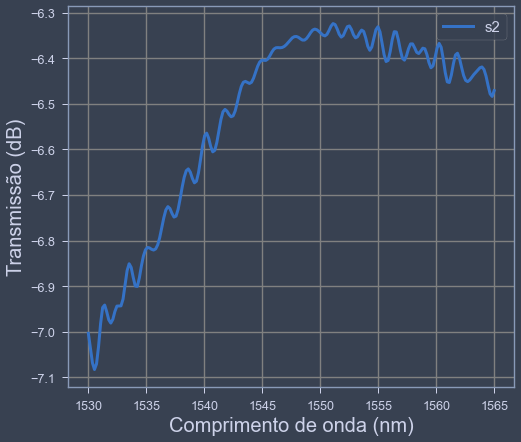

In [108]:
arquivo = open('temps12', 'rb')
treco = pickle.load(arquivo)
arquivo.close()
#plt.plot(x*1e9,10*np.log10(abs(s12[0,:])**2),label='s1',linewidth=3)
plt.plot(x*1e9,10*np.log10(treco[4]),label='s2',linewidth=3)
#plt.plot(x*1e9,10*np.log10(s12[2]),label='s2',linewidth=3)
#plt.plot(x*1e9,10*np.log10(s12[1,:]),label='s2',linewidth=3)
#plt.plot(x*1e9,10*np.log10(abs(s14)**2),label='porta4',linewidth=3)
#plt.plot(x*1e9,10*np.log10(abs(s15)**2),label='porta5',linewidth=3)
#plt.plot(x*1e9,10*np.log10(abs(s16)**2),label='porta6',linewidth=3)
plt.legend(fontsize=15)
#plt.ylim(-7,-5.5)
#plt.xlim(1530,1565)
#plt.yticks(np.arange(-7,-5.5,step=0.25),fontsize=15)
#plt.xticks(np.arange(1530,1565,step=5),fontsize=15)
plt.xlabel('Comprimento de onda (nm)',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')

In [17]:
mode.setnamed('TI1','y',(espessuraTotal/2 - espessuraTotal/12)) 
mode.setnamed('I1','y',(espessuraTotal/2 - espessuraTotal/12))
mode.setnamed('EME::Ports::port_1','y',(espessuraTotal/2 - espessuraTotal/12))


mode.setnamed('TO1','y',(espessuraTotal/2 - espessuraTotal/12))
mode.setnamed('O1','y',(espessuraTotal/2 - espessuraTotal/12))
mode.setnamed('EME::Ports::port_2','y',(espessuraTotal/2 - espessuraTotal/12))

mode.setnamed('TO2','y',(espessuraTotal/2 - 2*espessuraTotal/4 + espessuraTotal/12))
mode.setnamed('O2','y',(espessuraTotal/2 - 2*espessuraTotal/4 + espessuraTotal/12))
mode.setnamed('EME::Ports::port_3','y',(espessuraTotal/2 - 2*espessuraTotal/4 + espessuraTotal/12))

mode.setnamed('TO3','y',(espessuraTotal/2 - 2*espessuraTotal/4 - espessuraTotal/12))
mode.setnamed('O3','y',(espessuraTotal/2 - 2*espessuraTotal/4 - espessuraTotal/12))
mode.setnamed('EME::Ports::port_4','y',(espessuraTotal/2 - 2*espessuraTotal/4 - espessuraTotal/12))

mode.setnamed('TO4','y',(espessuraTotal/2 - 4*espessuraTotal/4 + espessuraTotal/12))     
mode.setnamed('O4','y',(espessuraTotal/2 - 4*espessuraTotal/4 + espessuraTotal/12))
mode.setnamed('EME::Ports::port_5','y',(espessuraTotal/2 - 4*espessuraTotal/4 + espessuraTotal/12))

In [9]:
k = [250,300,350,400]

for i in range(len(k)):
    print(i)

4
0
1
2
3


In [8]:
mode.emepropagate()

NameError: name 'mode' is not defined

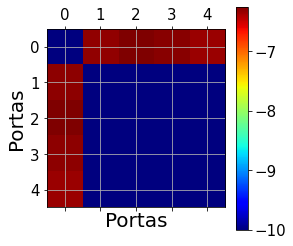

In [20]:
campo = mode.getresult('EME','user s matrix')
campo = abs(campo)**2
#campo = 10*np.log10(campo)
#[print(*line) for line in campo]
plt.matshow(10*np.log10(campo),cmap = 'jet',vmin=-10)
plt.xlabel('Portas',fontsize=20)
plt.ylabel('Portas',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.grid()
plt.savefig('MatrizS')

In [20]:
#np.savetxt('MatrizS.csv', campo, delimiter=',') 

In [21]:
mode.setemeanalysis("mode convergence sweep", 1)
mode.emesweep("mode convergence sweep")
modos = mode.getemesweep("S_mode_convergence_sweep")

KeyboardInterrupt: 

dict_keys(['modes', 's11', 's21', 's31', 's41', 's51', 's61', 's12', 's22', 's32', 's42', 's52', 's62', 's13', 's23', 's33', 's43', 's53', 's63', 's14', 's24', 's34', 's44', 's54', 's64', 's15', 's25', 's35', 's45', 's55', 's65', 's16', 's26', 's36', 's46', 's56', 's66', 'Lumerical_dataset'])


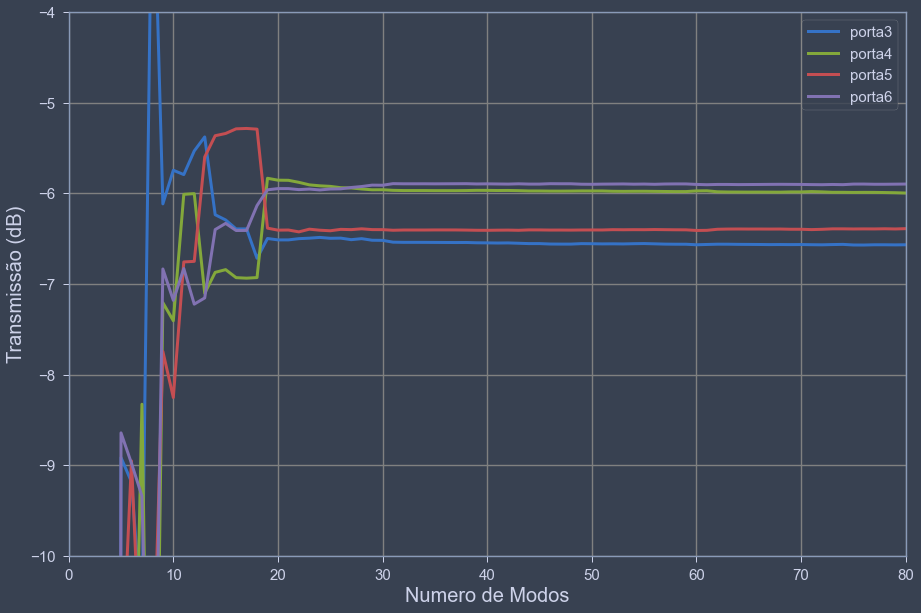

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
print(modos.keys())
x = modos['modes']
s13 = modos['s13']
s14 = modos['s14']
s15 = modos['s15']
s16 = modos['s16']

plt.plot(x,10*np.log10(abs(s13)**2),label='porta3',linewidth=3)
plt.plot(x,10*np.log10(abs(s14)**2),label='porta4',linewidth=3)
plt.plot(x,10*np.log10(abs(s15)**2),label='porta5',linewidth=3)
plt.plot(x,10*np.log10(abs(s16)**2),label='porta6',linewidth=3)
plt.legend(fontsize=15)
plt.ylim(-10,-5)
plt.yticks(np.arange(-10,-3,step=1),fontsize=15)
plt.xticks(np.arange(0,100,step=10),fontsize=15)
plt.xlim(0,80)
plt.xlabel('Numero de Modos',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')
plt.savefig('ConvergenciaModos')

In [23]:
mode.setemeanalysis("wavelength sweep",1)
mode.emesweep("wavelength sweep")
comprimentos = mode.getemesweep("S_wavelength_sweep")

dict_keys(['wavelength', 's11', 's21', 's31', 's41', 's51', 's12', 's22', 's32', 's42', 's52', 's13', 's23', 's33', 's43', 's53', 's14', 's24', 's34', 's44', 's54', 's15', 's25', 's35', 's45', 's55', 'Lumerical_dataset'])


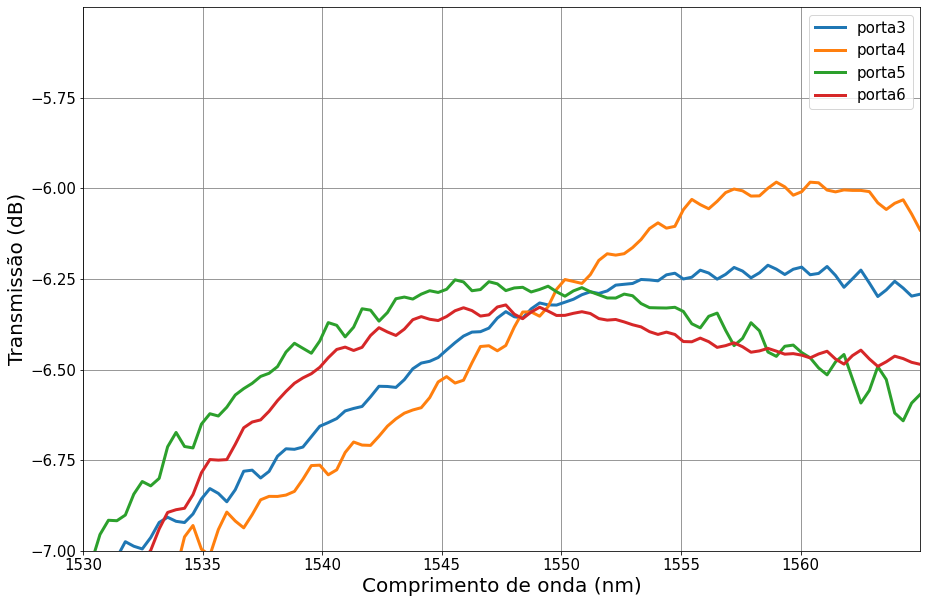

In [25]:



plt.plot(x*1e9,10*np.log10(abs(s13)**2),label='porta3',linewidth=3)
plt.plot(x*1e9,10*np.log10(abs(s14)**2),label='porta4',linewidth=3)
plt.plot(x*1e9,10*np.log10(abs(s15)**2),label='porta5',linewidth=3)
plt.plot(x*1e9,10*np.log10(abs(s16)**2),label='porta6',linewidth=3)
plt.legend(fontsize=15)
plt.ylim(-7,-5.5)
plt.xlim(1530,1565)
plt.yticks(np.arange(-7,-5.5,step=0.25),fontsize=15)
plt.xticks(np.arange(1530,1565,step=5),fontsize=15)
plt.xlabel('Comprimento de onda (nm)',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')
plt.savefig('sweepfrequencia')

In [ ]:
mode.setemeanalysis("propagation sweep",1)
mode.emesweep("propagation sweep")

dict_keys(['group_span_2', 's11', 's21', 's31', 's41', 's51', 's61', 's12', 's22', 's32', 's42', 's52', 's62', 's13', 's23', 's33', 's43', 's53', 's63', 's14', 's24', 's34', 's44', 's54', 's64', 's15', 's25', 's35', 's45', 's55', 's65', 's16', 's26', 's36', 's46', 's56', 's66', 'Lumerical_dataset'])


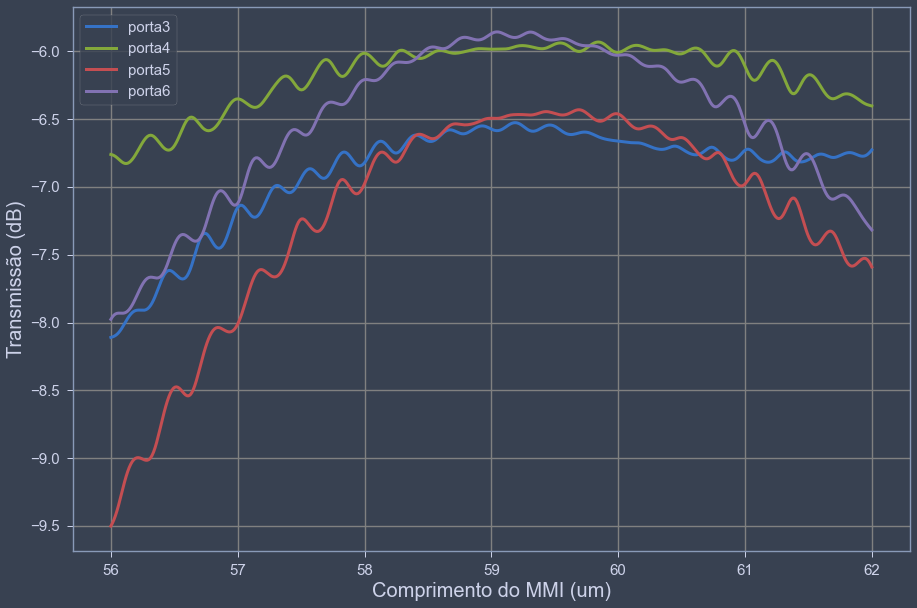

In [ ]:

largura = mode.getemesweep("S")

plt.rcParams["figure.figsize"] = (15,10)
print(largura.keys())
x = largura['group_span_2']
s13 = largura['s13']
s14 = largura['s14']
s15 = largura['s15']
s16 = largura['s16']

plt.plot(x*1e6,10*np.log10(abs(s13)**2),label='porta3',linewidth=3)
plt.plot(x*1e6,10*np.log10(abs(s14)**2),label='porta4',linewidth=3)
plt.plot(x*1e6,10*np.log10(abs(s15)**2),label='porta5',linewidth=3)
plt.plot(x*1e6,10*np.log10(abs(s16)**2),label='porta6',linewidth=3)
plt.legend(fontsize=15)
#plt.ylim(-7,-5.5)
#plt.xlim(56,62)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Comprimento do MMI (um)',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')
plt.savefig('sweepcomprimento')

dict_keys(['lambda', 'f', 'x', 'y', 'z', 'E', 'H', 'Lumerical_dataset'])


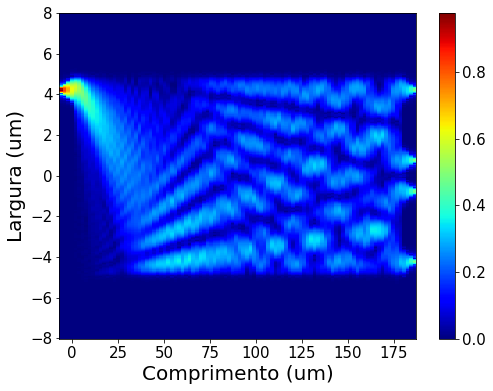

In [27]:
campo = mode.getresult('monitor','field profile')
print(campo.keys())
x = campo['x']
y = campo['y']
E = campo['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])

plt.rcParams["figure.figsize"] = (8,6)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Comprimento (um)',fontsize=20)
plt.ylabel('Largura (um)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.savefig('E linear')


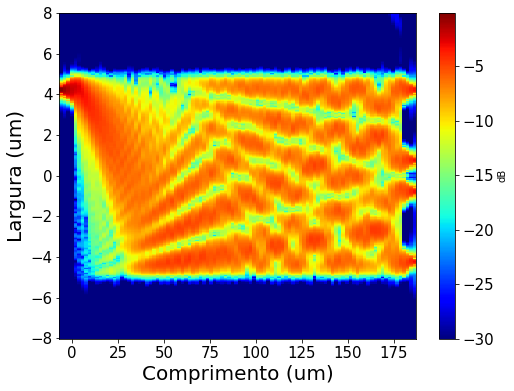

In [28]:
Elog = 10*np.log10(E)
plt.rcParams["figure.figsize"] = (8,6)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet',vmin=-30)
plt.xlabel('Comprimento (um)',fontsize=20)
plt.ylabel('Largura (um)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=15)
plt.savefig('E Log')